In [ ]:
#| default_exp trace

# Carbon Trace

> API details.

In [ ]:
#|export
from fastcore.utils import *
from carbontrace.network import *
import networkx as nx
from numpy.linalg import inv
from numpy.linalg import matrix_power
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from continuous_cmap.cmap import *
hex_list = ['#2AA364', '#F5EB4D', '#9E4229', '#381D02', '#381D02', '#381D02']
float_list=[0, 0.15, .6,.75,.8,1]
cmap_1000 = get_continuous_cmap(hex_list = hex_list, float_list = float_list)

## Model with system losses

Build a similar version of the Bialek sample network. This network has a operational emission rate and a node can have multiple feeder generation technologies. 

In [ ]:
bus = pd.read_csv('data/bus.csv')
bus

,ID_ST,LOAD,GENERATION,OER
0,I_HYDRO,0,10,0.0
1,I_GEO,0,10,0.1
2,I,10,0,0.0
3,II,0,45,1.0
4,III,10,0,0.0
5,IV,15,10,0.3
6,V,20,0,0.0
7,VI,20,0,0.0


In [ ]:
branch = pd.read_csv('data/branch.csv')
branch

,FROM_STATION,TO_STATION,FROM_MW,TO_MW
0,I_HYDRO,I,10,10
1,I_GEO,I,10,10
2,I,II,10,10
3,II,III,25,25
4,II,IV,15,15
5,III,IV,5,5
6,IV,V,15,15
7,V,VI,5,5
8,II,VI,15,15
9,III,V,10,10


## Scale up base generation

Using a directed networkx graph to represent the network.

In [ ]:
trace = Trace()
trace._network(bus, branch)

In [ ]:
#| export
@patch
def plot2(self:Trace, plot_nodes = None, oer=None ):
        self.fuel = {'I_HYDRO':'Hydro',
        'I_GEO':'Geothermal',
        'II':'Coal',
        'IV':'Geothermal'}
        pos = {'I':(0,0),
                    'II':(.5,0),
                    'III':(1,0),
                    'IV':(1,-.5),
                    'V':(1.5,0),
                    'VI':(1.5,.5),
                    'I_HYDRO':(-.35,0.35),
                    'I_GEO':(-.35,-.35)}
        
        sub_net = self.network.subgraph(plot_nodes) if plot_nodes else self.network
        fig = plt.figure(1, figsize=(20, 10), dpi=60)
        # node_cols = [cmap_1000(self.get_oer(x)[0]) for x in sub_net.nodes]
        # node_cols[1] = cmap_1000(.3)

        options = {
            "font_size": 20,
            "font_color":'black',
            "node_size": 5000,
            "node_color": 'red',
            # "edge_cmap": "cm.magma",
            "edgecolors": 'black',
            "arrowstyle":"->",
            "arrowsize":20,
            "width":5,
            "cmap": cmap_1000
        }

        tmp = nx.draw_networkx(sub_net, pos, **options)

        for x in sub_net.nodes:
            #GENERATION
            flip = 1
            if self.network.nodes[x]['GENERATION_MW'] > 0:
                plt.annotate(f'{round(self.network.nodes[x]["GENERATION_MW"],1)} MW', 
                                xy=(pos[x][0]-.06*np.sin(np.pi/4),
                                    pos[x][1]-.06*np.cos(np.pi/4)), 
                                xytext=(pos[x][0]-.2*np.sin(np.pi/4),
                                        pos[x][1]-.2*np.cos(np.pi/4)),
                                    color='black',
                                    fontsize=12,
                                arrowprops=dict(arrowstyle="->", 
                                                lw=4, 
                                                color="g"))
            #DEMAND
            if self.network.nodes[x]['DEMAND_MW'] > 0:
                plt.annotate(f'{round(self.network.nodes[x]["DEMAND_MW"],1)} MW', 
                            xy=(pos[x][0]+.06*np.sin(np.pi/4),
                                pos[x][1]-.06*np.cos(np.pi/4)), 
                            xytext=(pos[x][0]+.2*np.sin(np.pi/4)-.05,
                                    pos[x][1]-.2*np.cos(np.pi/4)),
                            color='r',fontsize=12,
                            arrowprops=dict(arrowstyle="<-", 
                        lw=4, color="red"))


#       
    
        edge_labels = {}
        for x in sub_net.edges:
#             print(x,self.pos[x[0]],self.pos[x[1]],0.5*abs(self.pos[x[0]][0]+self.pos[x[1]][0]))
            a = sub_net._adj[x[0]][x[1]]["FROM_MW"]
            b = sub_net._adj[x[0]][x[1]]["TO_MW"]
            c = ''+ str(a) + ' MW ' if a==b else ''+str(round(a,1))+' MW / '+str(round(b,1))+ ' MW '
            edge_labels[x] = c
#         cmap = mpl.cm.cool
#         norm = mpl.colors.Normalize(vmin=5, vmax=10)
#         ax = plt.gca()
#         plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
#              cax=ax, orientation='horizontal', label='Some Units')

        nx.draw_networkx_edge_labels(
                sub_net, pos,
                edge_labels=edge_labels,
                font_color='black',
                font_size =10
            )
        sm = plt.cm.ScalarMappable(cmap=cmap_1000)
        sm.set_array([])
        cbar = plt.colorbar(sm)
        cbar.ax.get_yaxis().labelpad = 10
        cbar.ax.set_ylabel('kgeCO2/kWh', rotation=270, fontsize=10)
        cbar.ax.set_title('Operating\n Emission Rate')
        plt.axis("off")
        return plt

In [ ]:
def imbalance(node):
    return sum([trace.network.edges[x]['TO_MW'] for x in trace.network.in_edges(node)]) + trace.network.nodes[node]['GENERATION_MW'] - \
           sum([trace.network.edges[x]['FROM_MW'] for x in trace.network.out_edges(node)]) -trace.network.nodes[node]['DEMAND_MW']

def apply_losses(loss = 0.08):
    for node in ['VI', 'V', 'IV', 'III', 'II','I']:# go through the nodes backwards
        trace.network.nodes[node]['GENERATION_MW'] =(1+loss) * trace.network.nodes[node]['GENERATION_MW'] # keep loads the same but increase generation by x%
        shortfall = imbalance(node)
        for edge in trace.network.in_edges(node):# each node needs to have line losses added to it in proportion to the existing mix
            sum_in = sum([trace.network.edges[x]['TO_MW'] for x in trace.network.in_edges(node)])
            trace.network.edges[edge]['TO_MW'] = trace.network.edges[edge]['TO_MW'] - shortfall*trace.network.edges[edge]['TO_MW']/sum_in
            trace.network.edges[edge]['FROM_MW'] = trace.network.edges[edge]['TO_MW'] * (1+loss)

        for node in ['I_GEO', 'I_HYDRO']: # make these edge generators match to balance network
            trace.network.nodes[node]['GENERATION_MW'] = sum([trace.network.edges[x]['FROM_MW'] for x in trace.network.out_edges(node)])

In [ ]:
trace = Trace()
trace._network(bus, branch)
apply_losses()
trace.process()
df = trace.df.loc[trace.df.sum(axis=1)!=0,trace.df.sum(axis=0)!=0]
# df = df.merge(bus.loc[:,['ID_ST','OER']], how='left', left_on='GENERATION', right_on='ID_ST').drop('ID_ST', axis=1)

/tmp/ipykernel_6987/908031070.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df = trace.df.loc[trace.df.sum(axis=1)!=0,trace.df.sum(axis=0)!=0]


<module 'matplotlib.pyplot' from '/opt/python/3.10.4/lib/python3.10/site-packages/matplotlib/pyplot.py'>

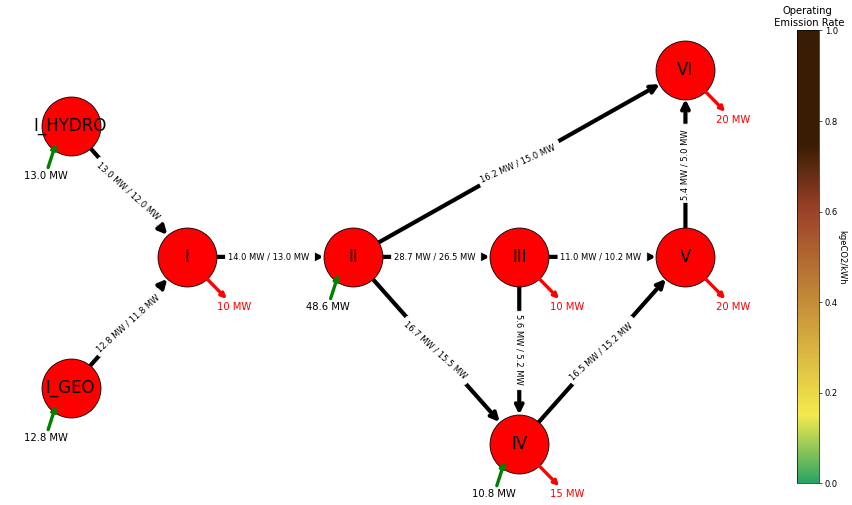

In [ ]:
trace.plot2(oer = dict(bus.loc[:,['ID_ST','OER']].values))

In [ ]:
oer = dict(bus.loc[:,['ID_ST','OER']].values)
oer

{'I_HYDRO': 0.0,
 'I_GEO': 0.1,
 'I': 0.0,
 'II': 1.0,
 'III': 0.0,
 'IV': 0.3,
 'V': 0.0,
 'VI': 0.0}

In [ ]:
df.assign(oer = df.GENERATION.map(oer))

,GENERATION,I_net,III_net,IV_net,V_net,VI_net,I_gross,III_gross,IV_gross,V_gross,VI_gross,oer
0,I_HYDRO,5.038884,1.063555,1.047583,1.688884,2.017553,5.441994,1.339773,1.346030,2.320499,2.636194,0.0
2,I_GEO,4.961116,1.047141,1.031415,1.662818,1.986415,5.358006,1.319095,1.325256,2.284686,2.595508,0.1
3,II,0.000000,7.889305,7.770825,12.527909,14.965934,0.000000,8.520449,8.560244,14.757500,16.765199,1.0
5,IV,0.000000,0.000000,5.150178,4.120389,1.030097,0.000000,0.000000,5.150178,4.450020,1.201505,0.3


In [ ]:
df = trace.df.loc[trace.df.sum(axis=1)!=0,trace.df.sum(axis=0)!=0]
df = df.merge(bus.loc[:,['ID_ST','OER']], how='left', left_on='GENERATION', right_on='ID_ST').drop('ID_ST', axis=1)

/tmp/ipykernel_6987/1678395552.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df = trace.df.loc[trace.df.sum(axis=1)!=0,trace.df.sum(axis=0)!=0]
